In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier  #GBM 
from sklearn import cross_validation, metrics  
from sklearn.grid_search import GridSearchCV   #Perforing grid search

In [2]:
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [3]:
train = pd.read_csv('[your file path]]GBM_new_train.csv')
target = 'Disbursed'

In [4]:
print train.head()

   Gender_Female  Gender_Male  Monthly_Income  Loan_Amount_Applied  \
0              1            0           20000               300000   
1              0            1           35000               200000   
2              0            1           22500               600000   
3              0            1           35000              1000000   
4              0            1          100000               500000   

   Loan_Tenure_Applied  Existing_EMI  Mobile_Verified_N  Mobile_Verified_Y  \
0                    5           0.0                  1                  0   
1                    2           0.0                  0                  1   
2                    4           0.0                  0                  1   
3                    5           0.0                  0                  1   
4                    2       25000.0                  0                  1   

   Var5  Var1_HAVC           ...            Source_Other  Source_S133  Var4  \
0     0          0           ..

In [5]:
# Fit the model with training data and Generate Model Report, has CV option

def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain['Disbursed'],
                                                    cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob)
    
    if performCV:
        print "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.9856
AUC Score (Train): 0.860941
CV Score : Mean - 0.8312238 | Std - 0.01041433 | Min - 0.8162053 | Max - 0.8448282


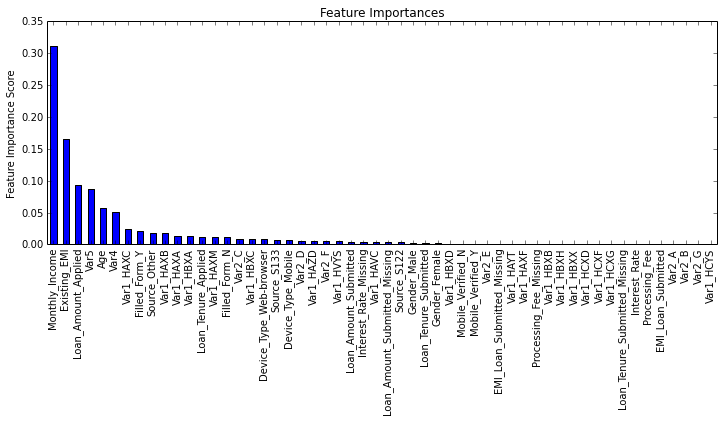

In [6]:
# Baseline Model

predictors = [x for x in train.columns if x not in [target]]
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, train, predictors)

In [ ]:
"""
NOTE:

Though, GBM is robust enough to not overfit with increasing trees, 
but a high number for pa particular learning rate can lead to overfitting. 
But as we reduce the learning rate and increase trees, 
the computation becomes expensive and would take a long time to run on standard personal computers.


1. Choose a relatively high learning rate. Generally the default value of 0.1 works 
   but somewhere between 0.05 to 0.2 should work for different problems
2. Determine the optimum number of trees for this learning rate. This should range around 40-70.
   Remember to choose a value on which your system can work fairly fast. 
   This is because it will be used for testing various scenarios and determining the tree parameters.
3. Tune tree-specific parameters for decided learning rate and number of trees. 
4. Lower the learning rate and increase the estimators proportionally to get more robust models.
"""

In [ ]:
"""
Below, th order to tuning the params is important!
"""

In [8]:
predictors = [x for x in train.columns if x not in [target]]

# FIRST: Find Optimal n_estimators

param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
        min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test1, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])

# read the output here
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.82952, std: 0.01210, params: {'n_estimators': 20},
  mean: 0.83230, std: 0.01161, params: {'n_estimators': 30},
  mean: 0.83506, std: 0.01217, params: {'n_estimators': 40},
  mean: 0.83584, std: 0.01196, params: {'n_estimators': 50},
  mean: 0.83600, std: 0.01210, params: {'n_estimators': 60},
  mean: 0.83571, std: 0.01220, params: {'n_estimators': 70},
  mean: 0.83471, std: 0.01218, params: {'n_estimators': 80}],
 {'n_estimators': 60},
 0.83599833068240526)

In [ ]:
"""
In the output above, 0.83599833068240526 is the cv score, by tuning the params, we are trying to get higher score
n_estimator = 60 is normal, normally it should be a value between (20, 100). 
If it's less than 20, try to lower learning rate
If it's higher than 100, try higher learning rate
"""

In [ ]:
"""
Below, start to tune Tree Params
"""

In [9]:
# SECOND: Find optimal max_depth and min_samples_split

param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,
                                            n_estimators=60, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])

# read the output here
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.83309, std: 0.00861, params: {'min_samples_split': 200, 'max_depth': 5},
  mean: 0.83369, std: 0.01173, params: {'min_samples_split': 400, 'max_depth': 5},
  mean: 0.83371, std: 0.01160, params: {'min_samples_split': 600, 'max_depth': 5},
  mean: 0.83283, std: 0.01334, params: {'min_samples_split': 800, 'max_depth': 5},
  mean: 0.83304, std: 0.01223, params: {'min_samples_split': 1000, 'max_depth': 5},
  mean: 0.83491, std: 0.00675, params: {'min_samples_split': 200, 'max_depth': 7},
  mean: 0.83725, std: 0.00849, params: {'min_samples_split': 400, 'max_depth': 7},
  mean: 0.83585, std: 0.00942, params: {'min_samples_split': 600, 'max_depth': 7},
  mean: 0.83647, std: 0.00867, params: {'min_samples_split': 800, 'max_depth': 7},
  mean: 0.83607, std: 0.00995, params: {'min_samples_split': 1000, 'max_depth': 7},
  mean: 0.82955, std: 0.01316, params: {'min_samples_split': 200, 'max_depth': 9},
  mean: 0.83187, std: 0.00688, params: {'min_samples_split': 400, 'max_depth': 9},
  

In [ ]:
"""
According to the above output, 
optimum max_depth = 7, min_samples_split = 400
Check the changes of mean here, it is these 2 values have the highest mean
But in practical, this maybe just local optimal choice, may not be the global one
"""

In [10]:
# THIRD: find optimal min_samples_leaf

param_test3 = {'min_samples_leaf':range(30,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
        n_estimators=60,max_depth=7,min_samples_split=400,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])

gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.83695, std: 0.01039, params: {'min_samples_leaf': 30},
  mean: 0.83701, std: 0.01102, params: {'min_samples_leaf': 40},
  mean: 0.83792, std: 0.00916, params: {'min_samples_leaf': 50},
  mean: 0.83871, std: 0.01016, params: {'min_samples_leaf': 60},
  mean: 0.83881, std: 0.00886, params: {'min_samples_leaf': 70}],
 {'min_samples_leaf': 70},
 0.83880816362330535)

In [13]:
# the mean above kept increasing, so min_samples_leaf = 70 may not be the optimal, try more here

param_test4 = {'min_samples_leaf':range(70,201,10)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
        n_estimators=60,max_depth=7,min_samples_split=400,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])

gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.83881, std: 0.00886, params: {'min_samples_leaf': 70},
  mean: 0.83788, std: 0.01011, params: {'min_samples_leaf': 80},
  mean: 0.83656, std: 0.00987, params: {'min_samples_leaf': 90},
  mean: 0.83594, std: 0.00961, params: {'min_samples_leaf': 100},
  mean: 0.83531, std: 0.00964, params: {'min_samples_leaf': 110},
  mean: 0.83740, std: 0.01153, params: {'min_samples_leaf': 120},
  mean: 0.83486, std: 0.01100, params: {'min_samples_leaf': 130},
  mean: 0.83660, std: 0.01130, params: {'min_samples_leaf': 140},
  mean: 0.83521, std: 0.01165, params: {'min_samples_leaf': 150},
  mean: 0.83658, std: 0.01200, params: {'min_samples_leaf': 160},
  mean: 0.83526, std: 0.01251, params: {'min_samples_leaf': 170},
  mean: 0.83648, std: 0.01402, params: {'min_samples_leaf': 180},
  mean: 0.83677, std: 0.01176, params: {'min_samples_leaf': 190},
  mean: 0.83904, std: 0.01079, params: {'min_samples_leaf': 200}],
 {'min_samples_leaf': 200},
 0.83904102024288318)


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.883273
CV Score : Mean - 0.839041 | Std - 0.01079107 | Min - 0.8239397 | Max - 0.8522687


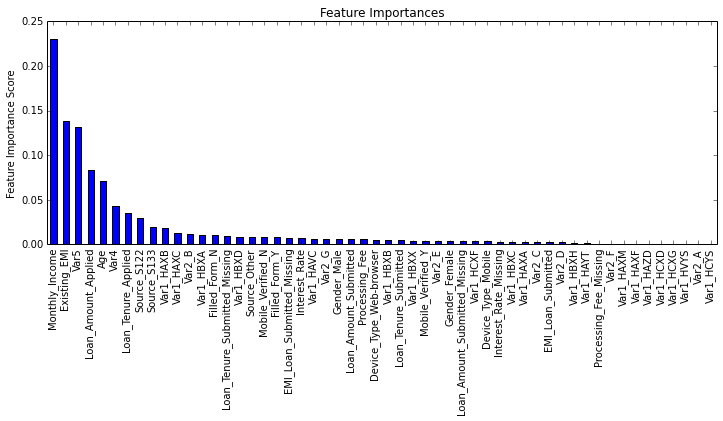

In [12]:
# In order to protect my machine, I will stop here and choose 200 as min_samples_leaf, 
# in fact we can keep increase and try to find the optimal one
modelfit(gsearch4.best_estimator_, train, predictors)

## In the output here, we will see more factors play rols in the prediction, 
## rather than focusing on a few factors as the baseline model

In [14]:
# FORTH: find optimal max_features

param_test5 = {'max_features':range(7,20,2)}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,
n_estimators=60, max_depth=7, min_samples_split=400, min_samples_leaf=200, subsample=0.8, random_state=10),
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])

gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.83904, std: 0.01079, params: {'max_features': 7},
  mean: 0.83582, std: 0.00781, params: {'max_features': 9},
  mean: 0.83808, std: 0.00849, params: {'max_features': 11},
  mean: 0.83856, std: 0.00980, params: {'max_features': 13},
  mean: 0.83874, std: 0.00767, params: {'max_features': 15},
  mean: 0.83857, std: 0.00944, params: {'max_features': 17},
  mean: 0.83635, std: 0.00711, params: {'max_features': 19}],
 {'max_features': 7},
 0.83904102024288318)

In [ ]:
"""
Optimal Tree Params:

min_samples_split: 400
min_samples_leaf: 200
max_depth: 7
max_features: 7
"""

In [15]:
# FIFTH: find optimal subsample

param_test6 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch6 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                n_estimators=60,max_depth=7,min_samples_split=200, 
                                min_samples_leaf=60, subsample=0.8, random_state=10,max_features=7),
param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])

gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.83494, std: 0.01201, params: {'subsample': 0.6},
  mean: 0.83622, std: 0.00917, params: {'subsample': 0.7},
  mean: 0.83541, std: 0.01066, params: {'subsample': 0.75},
  mean: 0.83597, std: 0.00977, params: {'subsample': 0.8},
  mean: 0.83686, std: 0.01164, params: {'subsample': 0.85},
  mean: 0.83905, std: 0.00905, params: {'subsample': 0.9}],
 {'subsample': 0.9},
 0.83905421972584016)


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.888323
CV Score : Mean - 0.839585 | Std - 0.009499227 | Min - 0.8256341 | Max - 0.8511341


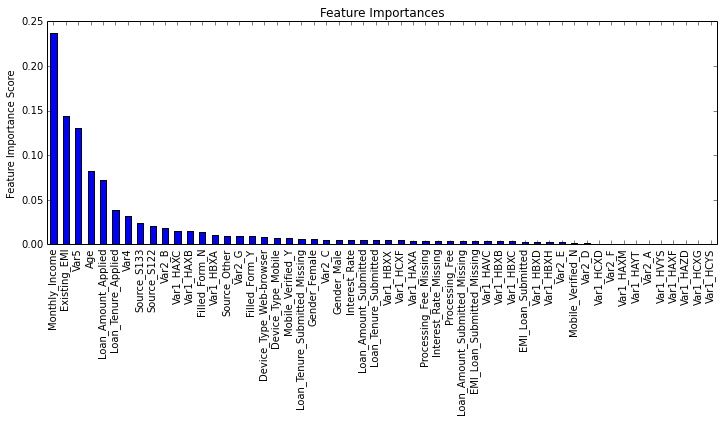

In [16]:
# SIXTH: tune learning rate

## half the learning rate, need to twice the n_estimators (# of trees)
predictors = [x for x in train.columns if x not in [target]]
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.05, 
                    n_estimators=120,max_depth=7, min_samples_split=400,min_samples_leaf=200, 
                                         subsample=0.9, random_state=10, max_features=7)
modelfit(gbm_tuned_1, train, predictors)


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.889348
CV Score : Mean - 0.8403237 | Std - 0.009452651 | Min - 0.8269372 | Max - 0.8511505


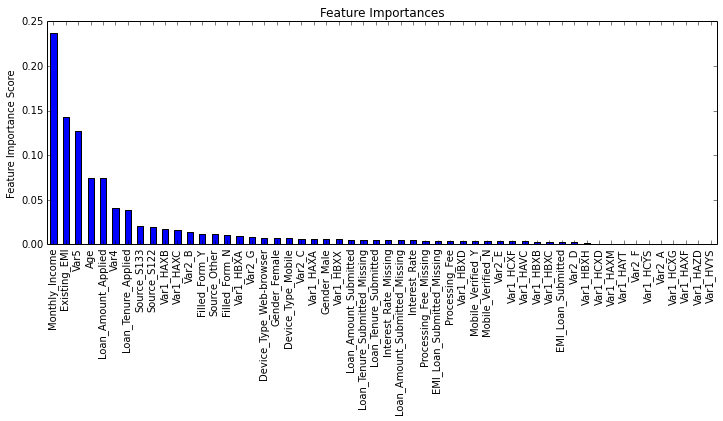

In [17]:
predictors = [x for x in train.columns if x not in [target]]
gbm_tuned_2 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=600,max_depth=7, 
                    min_samples_split=400,min_samples_leaf=200, subsample=0.9, random_state=10, max_features=7)
modelfit(gbm_tuned_2, train, predictors)


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.889118


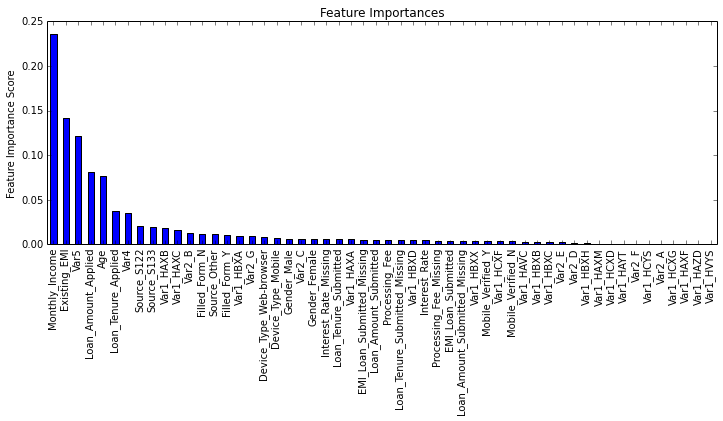

In [18]:
predictors = [x for x in train.columns if x not in [target]]
gbm_tuned_3 = GradientBoostingClassifier(learning_rate=0.005, n_estimators=1200,max_depth=7, 
                    min_samples_split=400, min_samples_leaf=200, subsample=0.9, random_state=10, max_features=7,
warm_start=True)
modelfit(gbm_tuned_3, train, predictors, performCV=False)